<a href="https://colab.research.google.com/github/kunai-3txk/colab/blob/main/20220524_Signate_Disease_Practice_lightgbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
from google.cloud import bigquery
project_id = 'nahe-project-01-344111'
client = bigquery.Client(project=project_id)
# 実行するクエリ
query =  """
                SELECT * FROM 
                `nahe-project-01-344111.Disease.Disease_train` 
                ;
         """
# メソッドに`to_dataframe()`をつけるとpd.DataFrameで結果を受け取れる
train = client.query(query).to_dataframe()
train.head()

,id,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,0,60,Male,2.9,1.3,170.9,42.1,37.1,5.5,2.9,1.01,1
1,1,28,Female,0.7,0.1,158.8,26.0,23.9,6.4,3.7,1.36,0
2,2,60,Male,23.1,12.5,962.0,53.0,40.9,6.8,3.3,0.96,1
3,3,20,Male,1.0,0.5,415.9,33.9,39.0,7.0,3.8,1.31,0
4,4,44,Female,0.6,0.3,152.9,40.9,42.0,4.5,2.1,1.04,0


In [10]:
# 実行するクエリ
query =  """
                SELECT * FROM 
                `nahe-project-01-344111.Disease.Disease_test` 
                ;
         """
# メソッドに`to_dataframe()`をつけるとpd.DataFrameで結果を受け取れる
test = client.query(query).to_dataframe()
test = pd.get_dummies(test, drop_first=True)
test.head()

,id,Age,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,Gender_Male
0,891,65,0.7,0.2,162.0,24.0,20.0,6.4,3.3,0.93,0
1,892,46,1.2,0.3,265.1,40.0,28.0,7.9,3.8,0.94,1
2,893,26,0.7,0.1,243.1,21.1,22.9,5.3,2.2,0.60,1
3,894,38,3.5,1.7,253.0,80.0,406.0,6.8,3.7,1.33,1
4,895,46,0.7,0.2,236.0,10.1,13.0,6.8,3.0,0.74,0


In [4]:
# モジュールのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [5]:
X = train.loc[:, (train.columns!='disease')]
X = pd.get_dummies(X, drop_first=True)
y = train['disease']
# 学習データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=0,stratify=y)

In [6]:
# 5-fold CVモデルの学習
# 5つのモデルを保存するリストの初期化
models = []

# 学習データの数だけの数列（0行から最終行まで連番）
row_no_list = list(range(len(y_train)))

# KFoldクラスをインスタンス化（これを使って5分割する）
K_fold = StratifiedKFold(n_splits=5, shuffle=True,  random_state=42)

# KFoldクラスで分割した回数だけ実行（ここでは5回）
for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
    # ilocで取り出す行を指定
    X_train_cv = X_train.iloc[train_cv_no, :]
    y_train_cv = pd.Series(y_train).iloc[train_cv_no]
    X_eval_cv = X_train.iloc[eval_cv_no, :]
    y_eval_cv = pd.Series(y_train).iloc[eval_cv_no]
    
    # 学習用
    lgb_train = lgb.Dataset(X_train_cv, y_train_cv,
                            free_raw_data=False)
    # 検証用
    lgb_eval = lgb.Dataset(X_eval_cv, y_eval_cv, reference=lgb_train,
                           free_raw_data=False)
    
    # パラメータを設定
    params = {'task': 'train',                # 学習、トレーニング ⇔　予測predict
              'boosting_type': 'gbdt',        # 勾配ブースティング
              'objective': 'multiclass',      # 目的関数：多値分類、マルチクラス分類
              'metric': 'multi_logloss',      # 分類モデルの性能を測る指標
              'num_class': 2,                 # 目的変数のクラス数
              'learning_rate': 0.02,          # 学習率（初期値0.1）
              'num_leaves': 23,               # 決定木の複雑度を調整（初期値31）
              'min_data_in_leaf': 1,          # データの最小数（初期値20）
             }
    
    # 学習
    evaluation_results = {}                                     # 学習の経過を保存する箱
    model = lgb.train(params,                                   # 上記で設定したパラメータ
                      lgb_train,                                # 使用するデータセット
                      num_boost_round=1000,                     # 学習の回数
                      valid_names=['train', 'valid'],           # 学習経過で表示する名称
                      valid_sets=[lgb_train, lgb_eval],         # モデル検証のデータセット
                      evals_result=evaluation_results,          # 学習の経過を保存
                      early_stopping_rounds=20,                 # アーリーストッピング# 学習
                      verbose_eval=-1)                          # 学習の経過の非表示
    
    # テストデータで予測する
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred_max = np.argmax(y_pred, axis=1)

    # Accuracy を計算する
    accuracy = sum(y_test == y_pred_max) / len(y_test)
    print('accuracy:', accuracy)
    
    # 学習が終わったモデルをリストに入れておく
    models.append(model) 

Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[140]	train's multi_logloss: 0.117674	valid's multi_logloss: 0.371858
accuracy: 0.8603351955307262
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[207]	train's multi_logloss: 0.0811977	valid's multi_logloss: 0.226797
accuracy: 0.88268156424581
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[112]	train's multi_logloss: 0.150681	valid's multi_logloss: 0.471202
accuracy: 0.8212290502793296
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[212]	train's multi_logloss: 0.0627692	valid's multi_logloss: 0.335528
accuracy: 0.8379888268156425
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[217]	train's multi_logloss: 0.0661831	valid's multi_logloss: 0.312195
accuracy: 0.8994413407821229


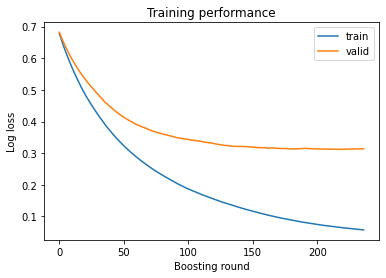

In [7]:
# 学習過程の可視化
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('Log loss')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.savefig('cv_logloss.jpg')
plt.show()

In [20]:
y_pred_final = model.predict(test, num_iteration=model.best_iteration)
y_pred_max = np.argmax(y_pred_final, axis=1)
y_pred_max.size

382

In [29]:
#891-1272
test_ID = [num for num in range(891,1273)]
np.array(test_ID).size

print(np.stack([test_ID, y_pred_max]).transpose())

[[ 891    0]
 [ 892    1]
 [ 893    0]
 [ 894    1]
 [ 895    1]
 [ 896    1]
 [ 897    0]
 [ 898    1]
 [ 899    0]
 [ 900    0]
 [ 901    1]
 [ 902    1]
 [ 903    1]
 [ 904    1]
 [ 905    0]
 [ 906    0]
 [ 907    1]
 [ 908    1]
 [ 909    1]
 [ 910    0]
 [ 911    0]
 [ 912    0]
 [ 913    0]
 [ 914    0]
 [ 915    1]
 [ 916    1]
 [ 917    0]
 [ 918    1]
 [ 919    1]
 [ 920    0]
 [ 921    1]
 [ 922    0]
 [ 923    1]
 [ 924    1]
 [ 925    0]
 [ 926    0]
 [ 927    1]
 [ 928    0]
 [ 929    0]
 [ 930    0]
 [ 931    1]
 [ 932    0]
 [ 933    0]
 [ 934    0]
 [ 935    0]
 [ 936    1]
 [ 937    1]
 [ 938    1]
 [ 939    0]
 [ 940    0]
 [ 941    1]
 [ 942    1]
 [ 943    1]
 [ 944    0]
 [ 945    1]
 [ 946    0]
 [ 947    0]
 [ 948    0]
 [ 949    1]
 [ 950    0]
 [ 951    0]
 [ 952    0]
 [ 953    0]
 [ 954    0]
 [ 955    1]
 [ 956    0]
 [ 957    0]
 [ 958    1]
 [ 959    1]
 [ 960    1]
 [ 961    1]
 [ 962    0]
 [ 963    1]
 [ 964    0]
 [ 965    1]
 [ 966    0]
 [ 967    0]